In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

from data import CreatePDEData, generate_params
from plot.plot_pde_data import plot_1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generating data pde_func!: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


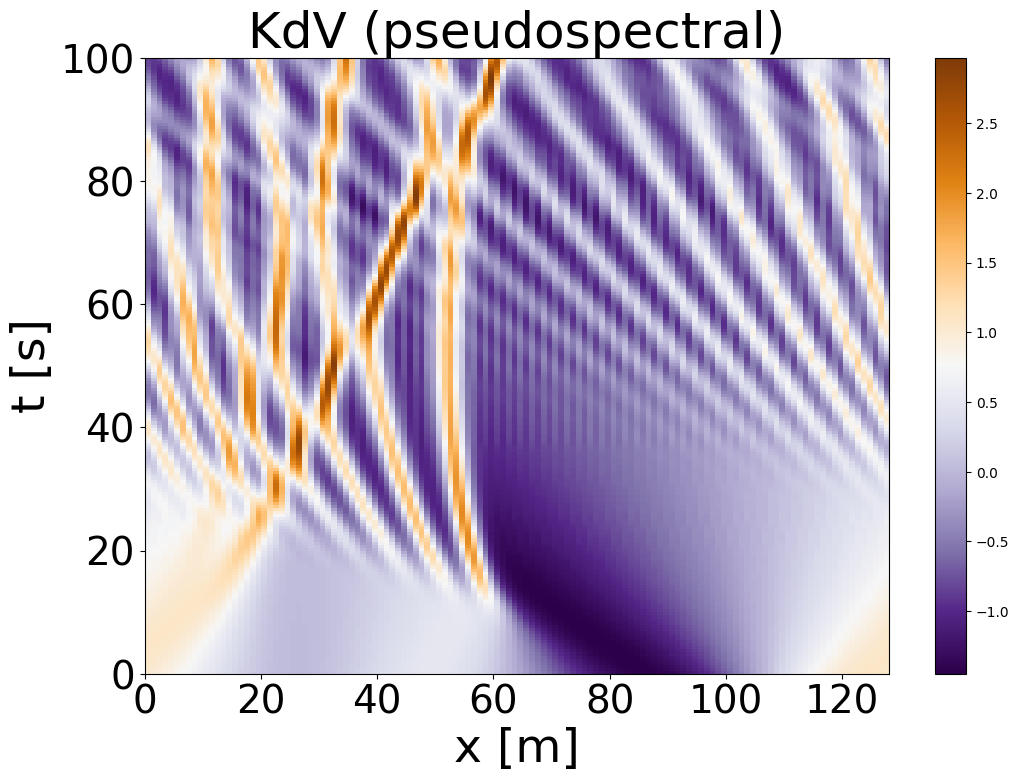

Generating data pde_func!: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


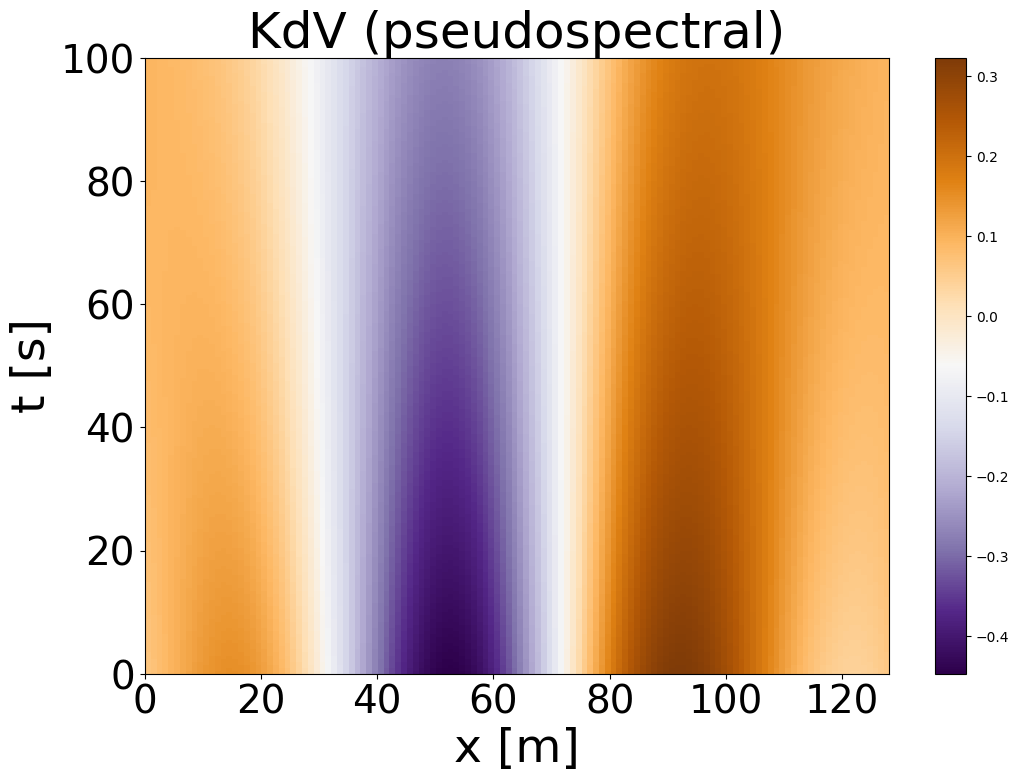

In [68]:
class PDE_Pseudospectral:
    def __init__(self, L):
        self.L = L

    def ux(self, u):
        return psdiff(u, order = 1, period=self.L)
    
    def uxx(self, u):
        return psdiff(u, order = 2, period=self.L)
    
    def uxxx(self, u):
        return psdiff(u, order = 3, period=self.L)
    
    def uxxxx(self, u):
        return psdiff(u, order = 4, period=self.L)
    
L = 128
T = 100

pde_ps = PDE_Pseudospectral(L=L)

pde_ps.pde1 = lambda t, u: 0.1 * pde_ps.uxx(u)
pde_ps.pde2 = lambda t, u: pde_ps.uxx(u)
pde_ps.pde3 = lambda t, u: -u * pde_ps.ux(u) - pde_ps.uxxx(u)

pde_data = CreatePDEData(L = L, N = 2**7, T = T, Nt = 200)
d = pde_data.get_data(pde_ps.pde3, tol = 1e-3)
plot_1d(d[0], L = L, T = T)

pde_data = CreatePDEData(L = L, N = 2**7, T = T, Nt = 200)
d = pde_data.get_data(pde_ps.pde2, tol = 1e-3)
plot_1d(d[0], L = L, T = T)

In [27]:
def initial_conditions(x: np.ndarray, L = 1) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    A, w, phi = generate_params()   
    u = np.sum(A * np.sin(w * x[:, None] / L + phi), -1)
    return u

In [ ]:
# Set the size of the domain, and create the discretized grid.
L = 128
N = 2**7
x = np.linspace(0, (1-1.0/N)*L, N)
# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

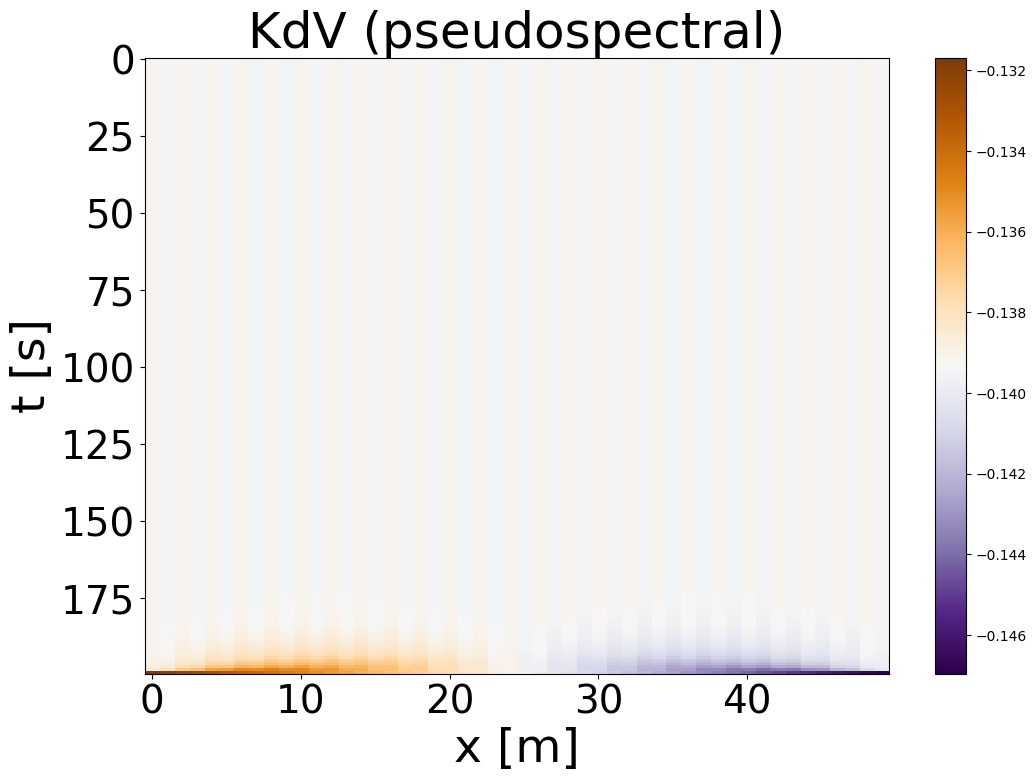

In [28]:
# Set the size of the domain, and create the discretized grid.
# L = 128
N = 50
# x = np.linspace(0, (1-1.0/N)*L, N)
x = np.linspace(0, 1, N)
# Set the tolerance of the solver
tol = 1e-2

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
Nt  = 200
t = np.linspace(0, 1, Nt)

fun = pde.pde2

# # Compute the solution using kdv_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=fun, 
                        t_span=[t[0], t[-1]], 
                        y0=u0, 
                        method='Radau', 
                        t_eval=t, 
                        # args=(L,), 
                        atol=tol, 
                        rtol=tol)

# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, cmap='PuOr_r', aspect='auto')
    plt.colorbar()
    plt.title('KdV (pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()

### LPSDA

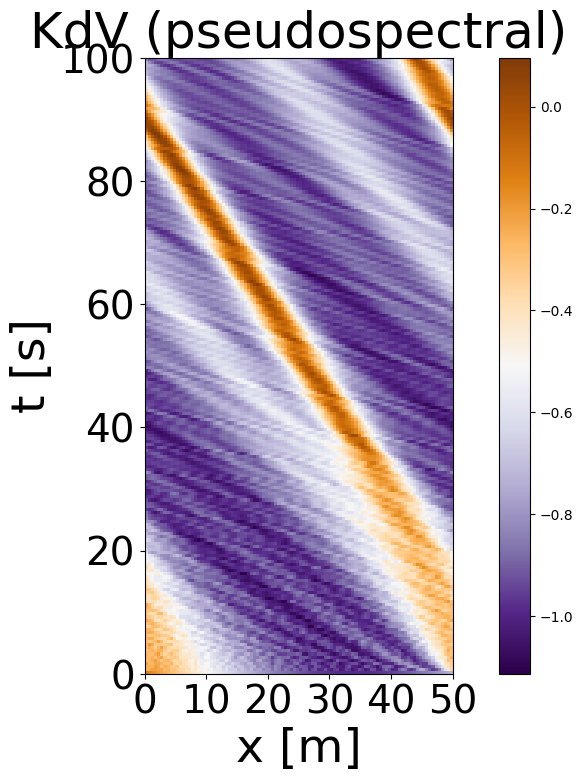

In [22]:
def kdv_pseudospectral(t, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KdV equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, order=1, period=L)
    uxxx = psdiff(u, order=3, period=L)
    uxx = psdiff(u, order=2, period=L)
    # Compute du/dt.    
    dudt = -u*ux - uxxx
    return dudt

def initial_conditions(x: np.ndarray) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """

    A, w, phi = generate_params()   
    u = np.sum(A * np.sin(w * x[:, None] + phi), -1)

    return u


# Set the size of the domain, and create the discretized grid.
L = 50
N = 100
x = np.linspace(0, 1, N)
# Set the tolerance of the solver
tol = 1e-3

# Set the initial conditions.
u0 = initial_conditions(x)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=kdv_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)


# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KdV (pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()

# Agao

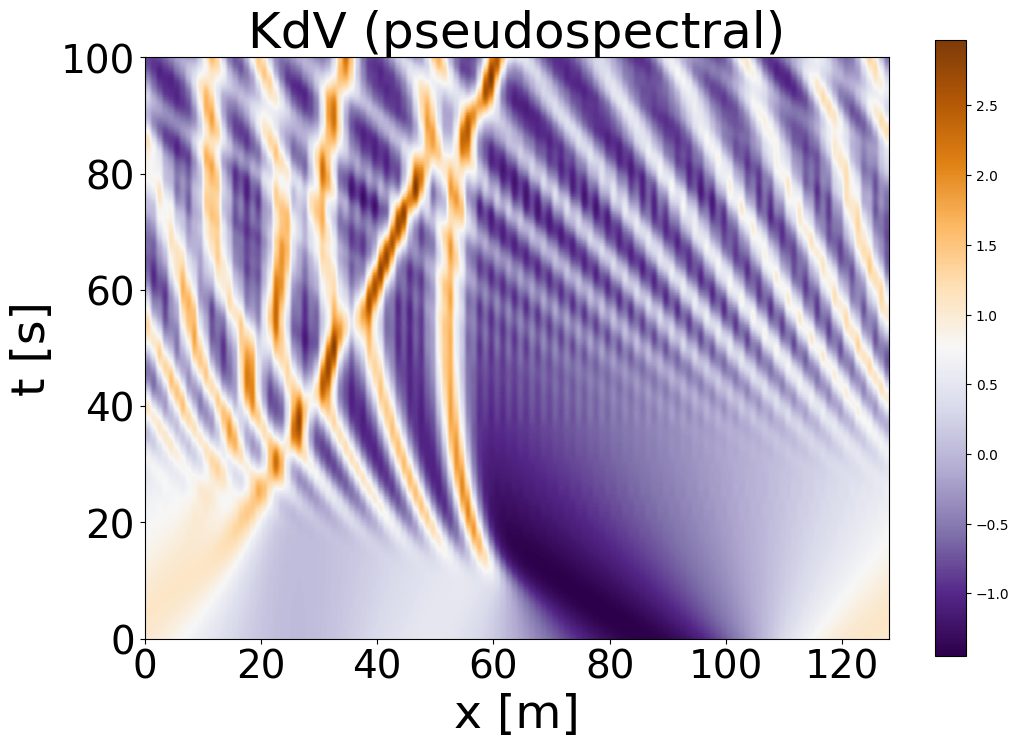

In [25]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, L: int, params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params   
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return u

def kdv_pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KdV equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, order=1, period=L)
    uxxx = psdiff(u, order=3, period=L)
    # Compute du/dt.    
    dudt = -u*ux - uxxx
    return dudt

# Set the size of the domain, and create the discretized grid.
L = 128
N = 2**7
x = np.linspace(0, (1-1.0/N)*L, N)
# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=kdv_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KdV (pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()